In [548]:
library(readxl)
library(data.table)
library(ggplot2)
library(ggprism)
library(ggforce)
library(ggetho)
library(ggsignif)
library(zoo)
theme_set(theme_prism(base_size=20))
options(repr.plot.width=15, repr.plot.height=15)
source("R/plot.R")
source("R/Cbind.R")
source("R/link_idoc_metadata.R")
source("R/library.R")
USE_MANUAL_SCORES <- FALSE

In [549]:
metadata <- data.table::fread("metadata.csv")

In [550]:
result_dir <- "/idoc_data/IDOC"
metadata_linked <- link_idoc_metadata(metadata, result_dir=result_dir, verbose=FALSE)
n_missing_animals <- nrow(metadata_linked[is.na(idoc_folder),])
if (n_missing_animals>0) {
    warning(paste(n_missing_animals, "animals could not be linked"))
}

In [551]:
metadata_linked <- metadata_linked[!is.na(idoc_folder),]
metadata_linked[, PRE_manual := PRE]
metadata_linked[, POST_manual := POST]

In [552]:
data.table::fwrite(x = metadata_linked, file = "IDOC_paper_metadata.csv")

In [553]:
# use raw csv
source("R/library.R")
data_raw <- load_idoc_data(
    # metadata_linked,#[Files=="2024-08-27_14-13-07_AOJ_ET",],#[Files=="2024-07-22_15-42-18_ET_AOJ_TEST",],
    # metadata_linked[Files=="2024-08-27_15-35-18_AOJ_ET",],#[Files=="2024-07-22_15-42-18_ET_AOJ_TEST",],
    # metadata_linked[Files=="2023-07-04_13-45-39(ET_3h)", ],
    # metadata_linked[substr(Files, 1, 10)=="2024-10-07",],
    metadata_linked,
    # how many exits need to happen for the trial to be considered?
    min_exits=3,
    # load from trial 1 and trial 2, applying the min_exit requirement to each separately
    trials=1:2,
    use_incomplete_tests = FALSE
)
# use chui annotation in excel file
# data <- data.table::copy(metadata_linked)

In [554]:
missing_data <- data_raw[is.na(PRE_1)&is.na(POST_1), .(.N, Files, ROI, experiment, PRE_1, POST_1), by=Files][, .SD[1], by=Files]
nrow(missing_data)

[1] 31

In [555]:
# missing_data

In [556]:
missing_data<-missing_data[N==20,]

In [557]:
file.remove("scripts/args.txt")
if (nrow(missing_data)!=0) {
    for (i in 1:nrow(missing_data)) {
        experiment_date <- missing_data$Files[i]
        print(experiment_date)
        working_directory <- file.path(result_dir, paste0(substr(experiment_date, 1, 7), "-idoc_data"), experiment_date)
        
        sessions <- yaml::read_yaml(file.path(working_directory, "sessions.yaml"))
        for (session_name in c("PRE", "PRE_1", "TRAIN_1", "TRAIN_2", "TRAIN_3", "TRAIN_4", "TRAIN_5", "TRAIN_6", "POST", "POST_1")) {
            if (session_name %in% toupper(names(sessions))) {
                experiment_folder <- sessions[[tolower(session_name)]]
                test <- unlist(strsplit(session_name, "_"))[1]
                # args <- paste("\"", working_directory, "\" ", "\"", experiment_folder, "\" ", toupper(test))
                args <- paste(working_directory, experiment_folder, toupper(test), sep=",")
                write(x = args, file = "scripts/args.txt", append = TRUE)
            }
        }
    }
}

Warning message in file.remove("scripts/args.txt"):
“cannot remove file 'scripts/args.txt', reason 'No such file or directory'”


[1] FALSE

In [558]:
options(repr.matrix.max.rows=600, repr.matrix.max.cols=200)
data.table::fwrite(x=missing_data, file = "reanalyze.csv")

In [559]:
data_raw[,PRE_machine := PRE]
data_raw[,PRE_1_machine := PRE_1]
data_raw[,PRE_2_machine := PRE_2]
data_raw[,POST_machine := POST]
data_raw[,POST_1_machine := POST_1]
data_raw[,POST_2_machine := POST_2]
# data_raw[,.(Files, ROI, experiment, POST_1_machine, POST_2_machine, POST_1_manual, POST_2_manual, POST_manual, POST_machine, diff=POST_manual-POST_machine)]

In [560]:
hits <- data_raw[, .(Files, idoc_folder, User, PRE_found=sapply(PRE_files, function(x) {!any(is.na(x))}), POST_found=sapply(POST_files, function(x) {!any(is.na(x))}))]

In [561]:
data_raw[,PRE_machine := PRE]
data_raw[,PRE_1_machine := PRE_1]
data_raw[,PRE_2_machine := PRE_2]
data_raw[,POST_machine := POST]
data_raw[,POST_1_machine := POST_1]
data_raw[,POST_2_machine := POST_2]

In [562]:
USE_MANUAL_SCORES

[1] FALSE

In [563]:
if (USE_MANUAL_SCORES) {
  message("Using human made scores")   
  data_raw[ , PRE := PRE_manual]
  data_raw[ , POST := POST_manual]
} else {
  message("Using machine made scores")   
  data_raw[ , PRE := PRE_machine]
  data_raw[ , POST := POST_machine]
}


Using machine made scores



In [565]:
# 0.1 % of machine PRE deviates from manual PRE
data_raw[, .(mean(abs(PRE_machine-PRE_manual)>0.01, na.rm = T))] 

V1
<dbl>
0.3


In [566]:
# 19 % of machine POST deviates from machine POST
data_raw[, .(mean(abs(POST_machine-POST_manual)>0.1, na.rm = T))] 

V1
<dbl>
0.2026266


Warning message in plot_theme(plot):
“The `legend.text.align` theme element is not defined in the element hierarchy.”
Warning message in plot_theme(plot):
“The `legend.title.align` theme element is not defined in the element hierarchy.”
Warning message:
“Removed 717 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message in plot_theme(plot):
“The `legend.text.align` theme element is not defined in the element hierarchy.”
Warning message in plot_theme(plot):
“The `legend.title.align` theme element is not defined in the element hierarchy.”
Warning message:
“Removed 924 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message in plot_theme(plot):
“The `legend.text.align` theme element is not defined in the element hierarchy.”
Warning message in plot_theme(plot):
“The `legend.title.align` theme element is not defined in the element hierarchy.”


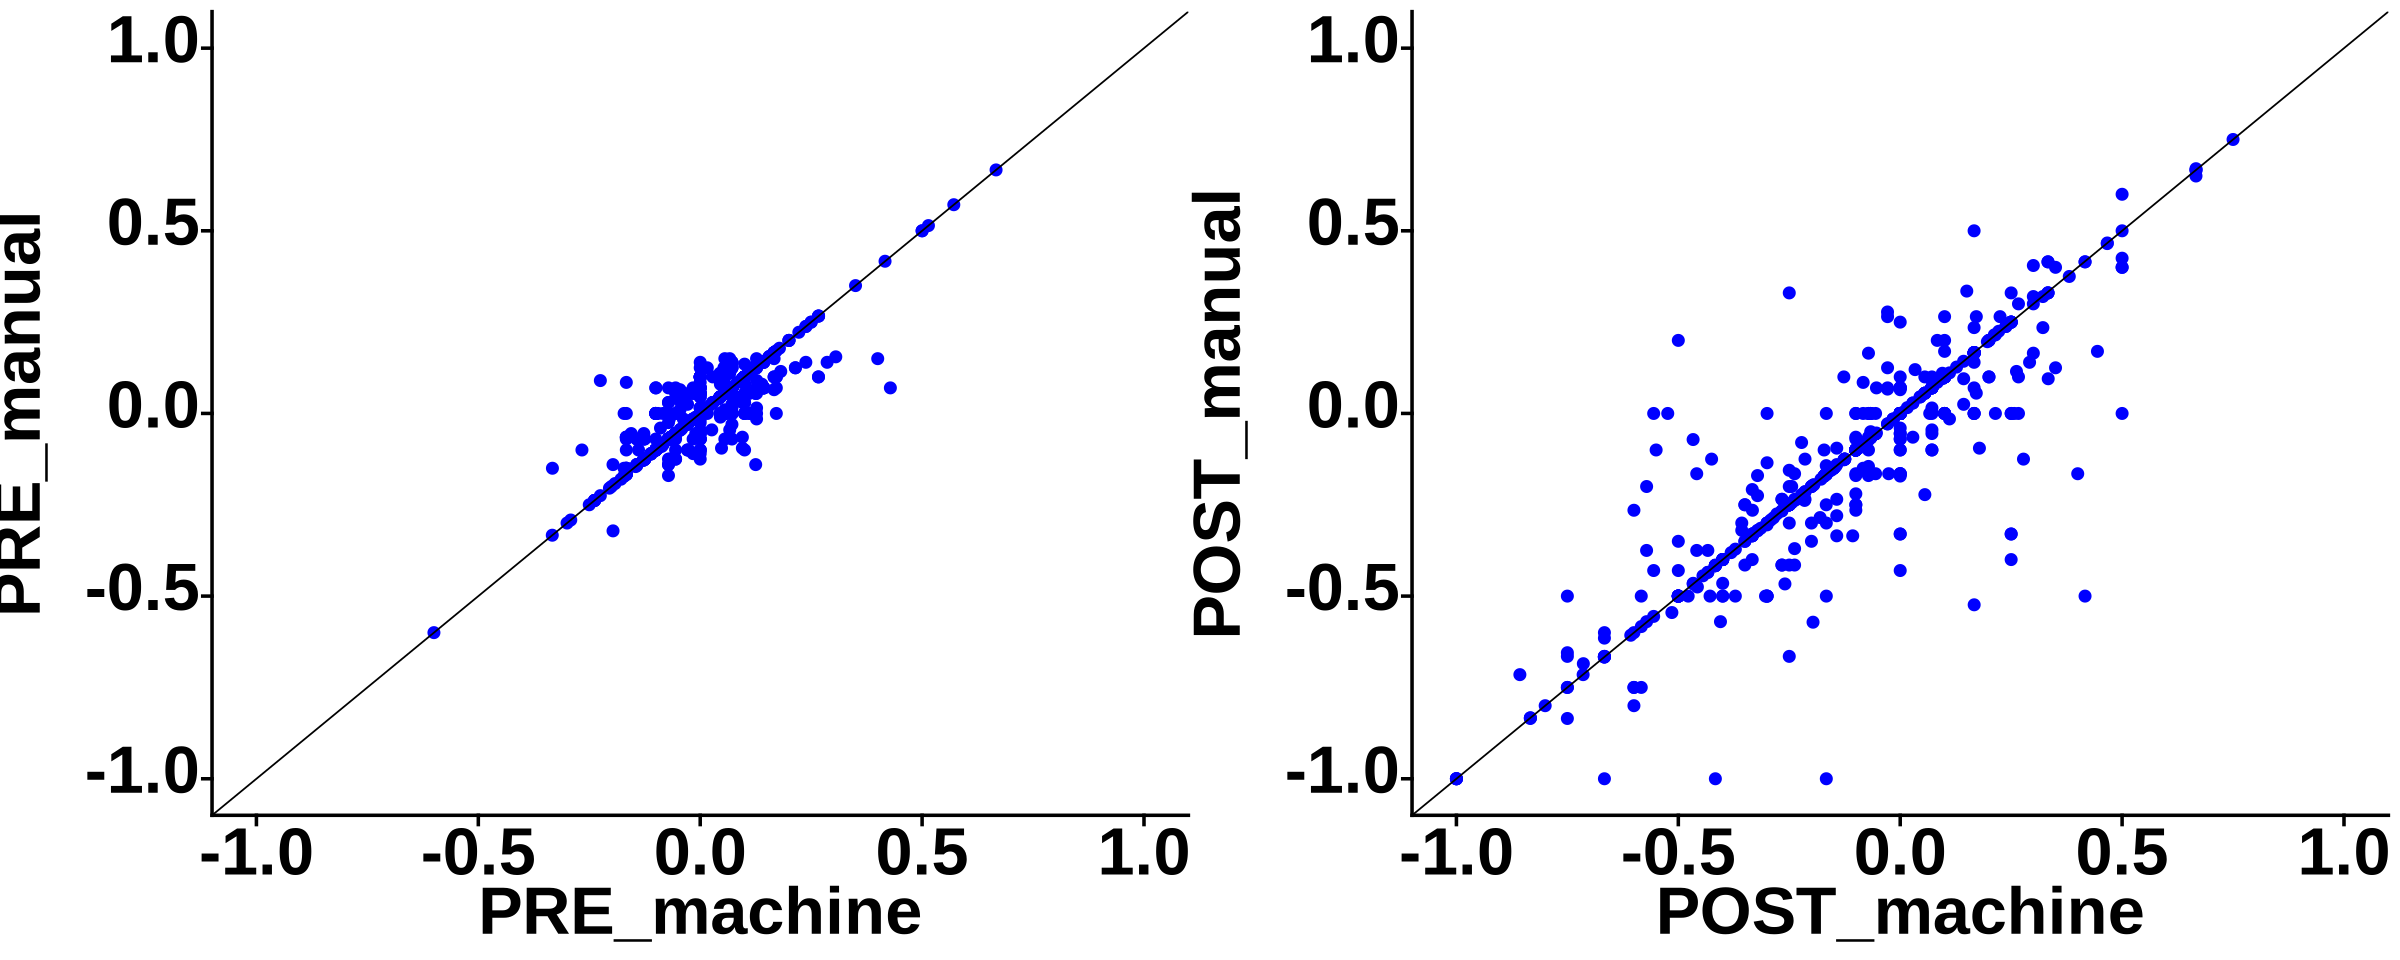

In [567]:
options(repr.plot.width=20, repr.plot.height=8)
gg_pre <- ggplot(
    data=data_raw,
    aes(x=PRE_machine, y=PRE_manual)
) +
    geom_point(color="blue", size=3) +
    geom_abline(intercept = 0, slope = 1) +
    scale_y_continuous(limits=c(-1, 1), breaks=seq(-1, 1, 0.5)) +
    scale_x_continuous(limits=c(-1, 1), breaks=seq(-1, 1, 0.5))

gg_post <- ggplot(
    data=data_raw,
    aes(x=POST_machine, y=POST_manual)
) +
    geom_point(color="blue", size=3) +
    geom_abline(intercept = 0, slope = 1) +
    scale_y_continuous(limits=c(-1, 1), breaks=seq(-1, 1, 0.5)) +
    scale_x_continuous(limits=c(-1, 1), breaks=seq(-1, 1, 0.5))
cowplot::plot_grid(gg_pre, gg_post, ncol=2)

In [568]:
data_raw[, disagreement := abs(POST_machine - POST_manual)]
data_raw[order(-disagreement),][1:10, .(POST_machine, POST_manual, disagreement, Files, ROI)]

POST_machine,POST_manual,disagreement,Files,ROI
<dbl>,<dbl>,<dbl>,<chr>,<int>
0.4165000,-0.5000000,0.9165000,2021-12-22 (CH),10
-0.1665000,-1.0000000,0.8335000,2021-11-04 (CH),7
-0.5000000,0.2000000,0.7000000,2021-10-01 (CH2),5
0.1666667,-0.5238095,0.6904762,2023-06-13_15-41-34(ESB-GTACR2),8
0.2500000,-0.4000000,0.6500000,2021-10-28 (CH),8
-0.4165000,-1.0000000,0.5835000,2021-10-01 (CH2),3
0.2500000,-0.3300000,0.5800000,2021-10-01 (CH2),16
-0.2500000,0.3300000,0.5800000,2021-10-05 (CH),4
0.2500000,-0.3300000,0.5800000,2021-12-22 (CH),19


In [569]:
data <- data_raw

In [570]:
# format interactor time window so it is either NONE or one of the ZTs
# generate the column SD_status to summarise SD_quality and SD_quality_second_eye
data[, SD_status := "NONE"]
data[interactor_time_window!="No_stimulator" & !(SD_quality == "good" & SD_quality_second_eye == "good"), SD_status := "bad"]
data[SD_quality == "good" & SD_quality_second_eye == "good", SD_status := "good"]
# unknown = gtacr flies
data[SD_quality == "unknown" & SD_quality_second_eye == "unknown", SD_status := "unknown"]

data[ , interval := interactor_time_window]
data[ , interactor_time_window := NULL]
data[, SD_quality := NULL]
data[, SD_quality_second_eye := NULL]

In [571]:
data <- data[!is.na(POST) & !is.na(PRE),]

In [572]:
data<-data[abs(PRE)<=0.2,]

In [573]:
# verify there are not repeats (the same fly represent more than once)
counts <- data[, .N, by=fly_name_reference]
stopifnot(all(counts$N==1))

In [574]:
data[, id := 1:.N]

In [575]:
data_long <- melt(data = data, measure.vars = c("PRE", "POST"), value.name = "PI", variable.name = "test")
data.table::fwrite(x = data_long, file = "tidy_data.csv")
data.table::fwrite(x = data, file = "tidy_data_wide.csv")


In [576]:
data[substr(Files, 1, 10)=="2024-10-15",]

Files,sheet,fly_name_reference,date,reference_hour,machine_name,region_id,ROI,Genotype,Gender,Age,interactor,Training,comment on SD,User,experiment,PRE_1,PRE_2,PRE,POST_1,POST_2,POST,folder__,sheet__,idoc_folder,PRE_manual,POST_manual,PRE_n_exits,PRE_files,PRE_1_manual,PRE_2_manual,POST_n_exits,POST_files,POST_1_manual,POST_2_manual,PRE_machine,PRE_1_machine,PRE_2_machine,POST_machine,POST_1_machine,POST_2_machine,disagreement,SD_status,interval,id
<chr>,<chr>,<chr>,<IDate>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<list>,<chr>,<chr>,<int>,<list>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>


In [577]:
table(data$interactor)


    DefaultStimulator                  NONE   RobustSleepDepriver 
                  378                   117                    42 
StaticSleepStimulator 
                   25 

Warning message in plot_theme(plot):
“The `legend.text.align` theme element is not defined in the element hierarchy.”
Warning message in plot_theme(plot):
“The `legend.title.align` theme element is not defined in the element hierarchy.”


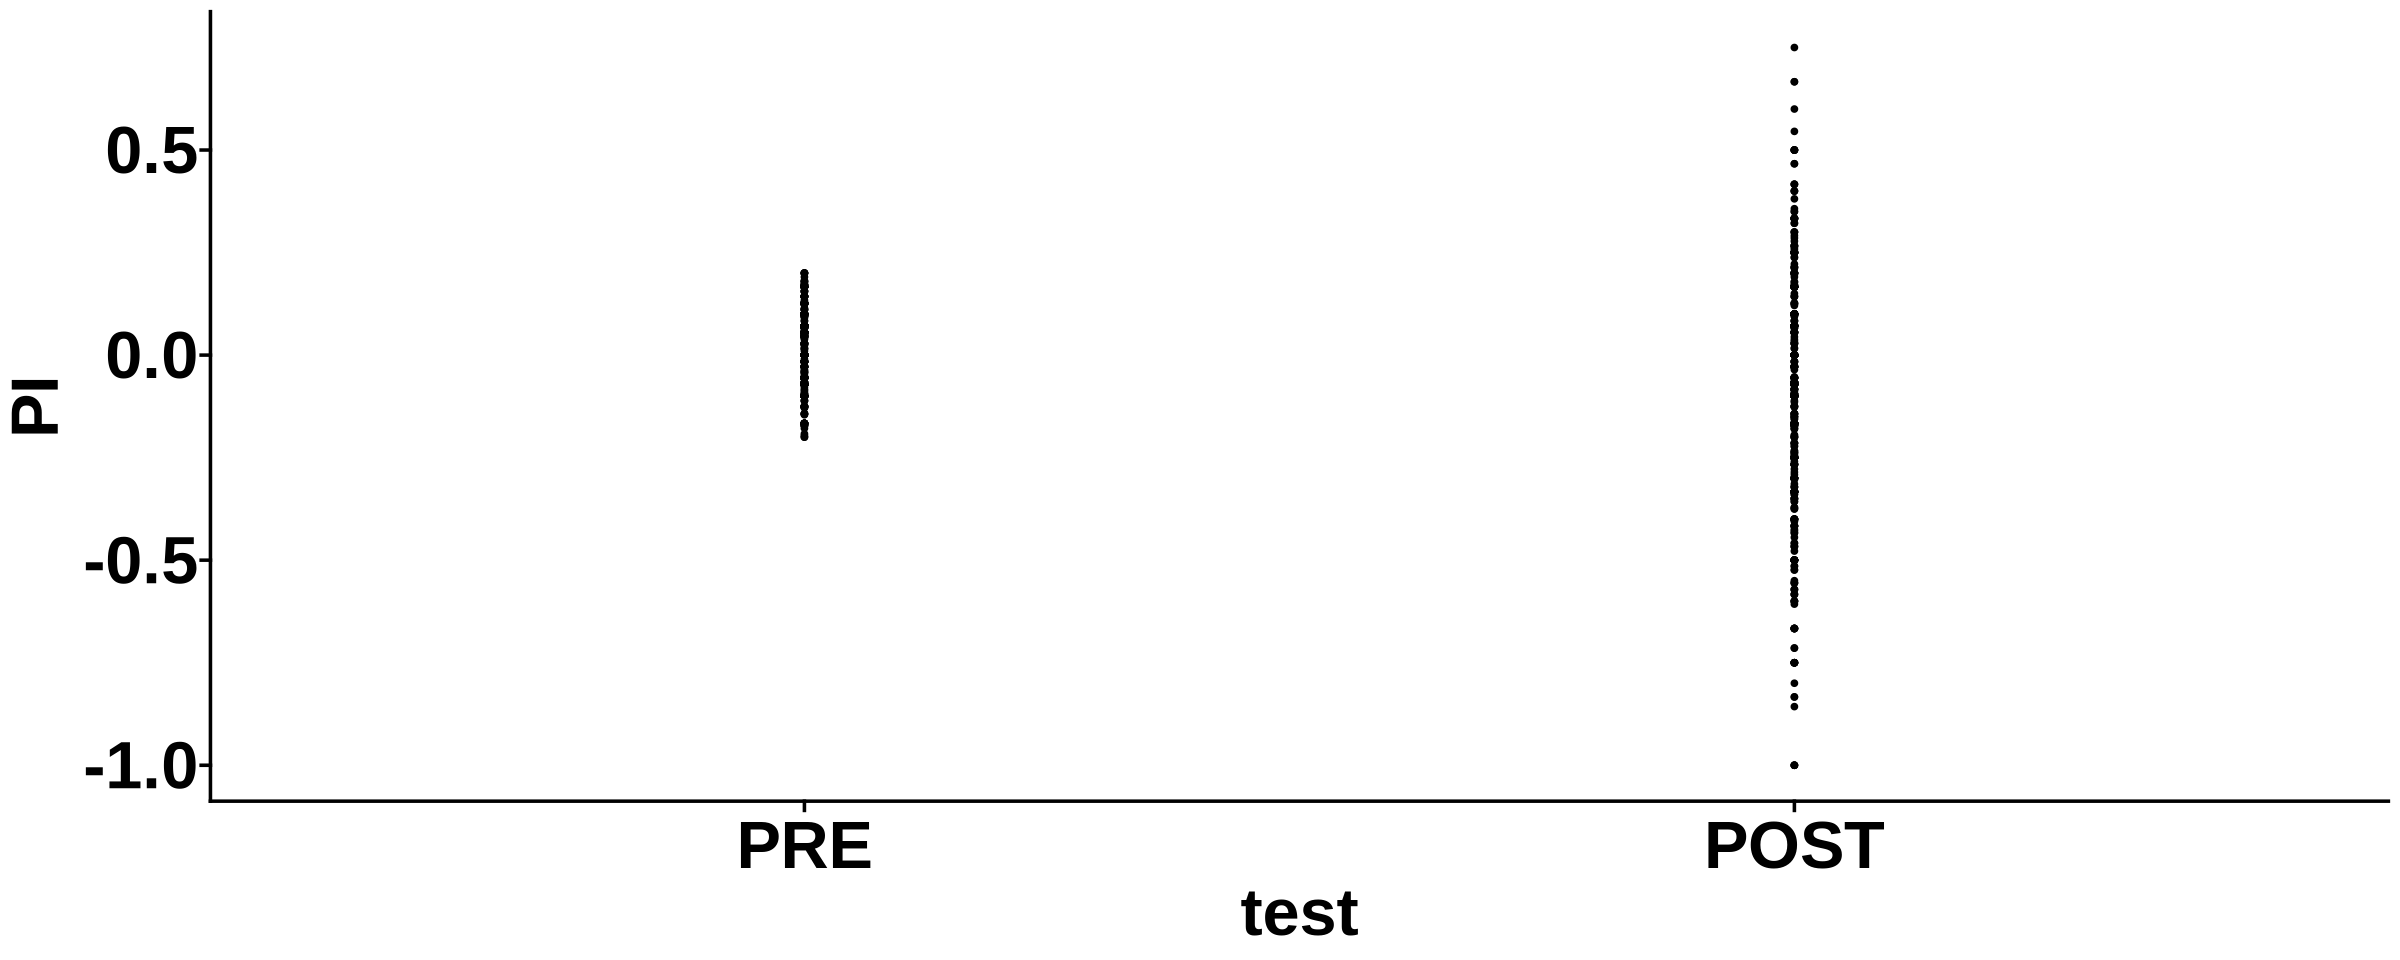

In [578]:
ggplot(data=data_long, aes(x=test, y=PI)) + geom_point()

In [515]:
# data[, .(Files, idoc_folder, sheet, ROI, PRE, PRE_1, PRE_1_manual, PRE_2, PRE_2_manual, POST_1, POST_1_manual, POST_2, POST_2_manual)]
# data[Genotype=="orb2", .N, by=experiment]
# data(metadata_linked$interactor_time_window)
# hits[, .N, by=.(PRE_found, User)][order(PRE_found),]
# hits[, .N, by=.(POST_found, User)][order(POST_found),]
# metadata_linked[Training=="6X_Spaced" & interactor_time_window=="No_stimulator" & region_id != "NONE" & !is.na(PRE) & !is.na(POST)]
# table(metadata_linked$region_id)
# data[Genotype=="orb2", .N, by=experiment]